# Trump Tweet EDA

The Data For this notebook is from the trump twitter archive: http://www.trumptwitterarchive.com/archive

In it we'll just be epxloring some of the statistics of how trump tweets as well as look at a few ways his tweeting changes over time.

In [1]:
%load_ext lab_black
import pandas as pd
import numpy as np
import nltk
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (23.0, 10.0)

import eda_utils as ef

#### Import the data as a pandas dataframe

In [2]:
DATA_FILE = "./data/archive.json"

df = pd.read_json(DATA_FILE)
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for Android,682703233492619264,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49+00:00,6776,NaN,16495,False
1,Twitter for Android,682700657304989696,"Do you believe that The State Department, on N...",2015-12-31 23:11:35+00:00,2755,NaN,6824,False
2,Twitter for iPhone,682635132038176768,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 18:51:12+00:00,2468,NaN,6047,False
3,Twitter for iPhone,682605293856002048,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 16:52:38+00:00,2080,NaN,8416,False
4,Twitter for Android,682578783912759296,I would feel sorry for @JebBush and how badly ...,2015-12-31 15:07:18+00:00,1875,NaN,5780,False


In [3]:
df.describe()

,id_str,retweet_count,in_reply_to_user_id_str,favorite_count
count,3.630700e+04,36307.000000,2.540000e+03,36307.000000
mean,5.565226e+17,4396.954637,3.390529e+08,15462.973724
std,2.481136e+17,9442.712839,3.974974e+08,34777.231080
min,1.698309e+09,0.000000,7.425000e+03,0.000000
25%,3.511359e+17,19.000000,3.576461e+07,22.000000
50%,5.448598e+17,187.000000,2.162993e+08,96.000000
75%,7.109204e+17,3700.000000,4.749732e+08,6161.000000
max,1.079888e+18,369530.000000,3.412873e+09,633253.000000


Check all tweets are unique

In [4]:
no_tweets, _ = df.shape
print("Number of tweets:", no_tweets)
# Check Id stings are all unique
print("All unique:", no_tweets == df["id_str"].nunique())

Number of tweets: 36307
All unique: True


## Data Cleaning
#### Check Dataset is clean:

In [5]:
# Check for empty values
df.isna().sum()

source                         0
id_str                         0
text                           0
created_at                     0
retweet_count                  0
in_reply_to_user_id_str    33767
favorite_count                 0
is_retweet                     0
dtype: int64

We don't have any NaN values in any of the columns we want to investigate which is good.

### Regex filtering
#### We only want normal characters, hastags, and links.

In [6]:
# Count external links before cleaning them so we can investigate
count_external_links = lambda x: len([x for x in x.split() if x.startswith("http")])
df["ext_links"] = df["text"].apply(count_external_links)

# Clean the tweets
df["text"] = df["text"].apply(ef.tweet_cleaner)

# Remove tweets that just contain empty strings or single spaces
df = df[(df["text"] != "") | (df["text"] != " ")]

## Look at some sample tweets:

In [9]:
for i in np.random.choice(df.index, 5, replace=False):
    print("Tweet #{}:\n{}".format(i, df.text[i]))
    print("_" * 40)

Tweet #11666:
I'm leaving now for Burlington, Vermont. It will be wild!
________________________________________
Tweet #9471:
Read my full statement here on the Supreme Court's executive amnesty decision #imwithyou 
________________________________________
Tweet #20230:
FLASHBACK: Alex Salmond pleaded with Donald Trump to back release of Lockerbie bomber 
________________________________________
Tweet #22752:
The Supercommittee is a disaster. The Republicans made a crucial mistake agreeing to this debt deal. They hat (cont) 
________________________________________
Tweet #28068:
I have no doubt that Mitt will do really well tonight. We'll all be watching .
________________________________________


## General Stats
----
We will use these later to define a better cost function.
#### Number of tokens in corpus

In [7]:
tknzr = nltk.tokenize.TweetTokenizer()
words = tknzr.tokenize(" ".join(df.text))
value_counts = pd.value_counts(words)
print("Most probable characters: ")
print(value_counts.head(15))
print("-" * 20)
print("Number of non-unique tokens:")
print((value_counts > 1).sum())

Most probable characters: 
.      35412
"      23793
!      20813
the    20703
,      19804
to     14526
:      13774
and    10917
a      10385
is      9597
of      9550
in      8611
for     7491
I       7391
you     7202
dtype: int64
--------------------
Number of non-unique tokens:
16089


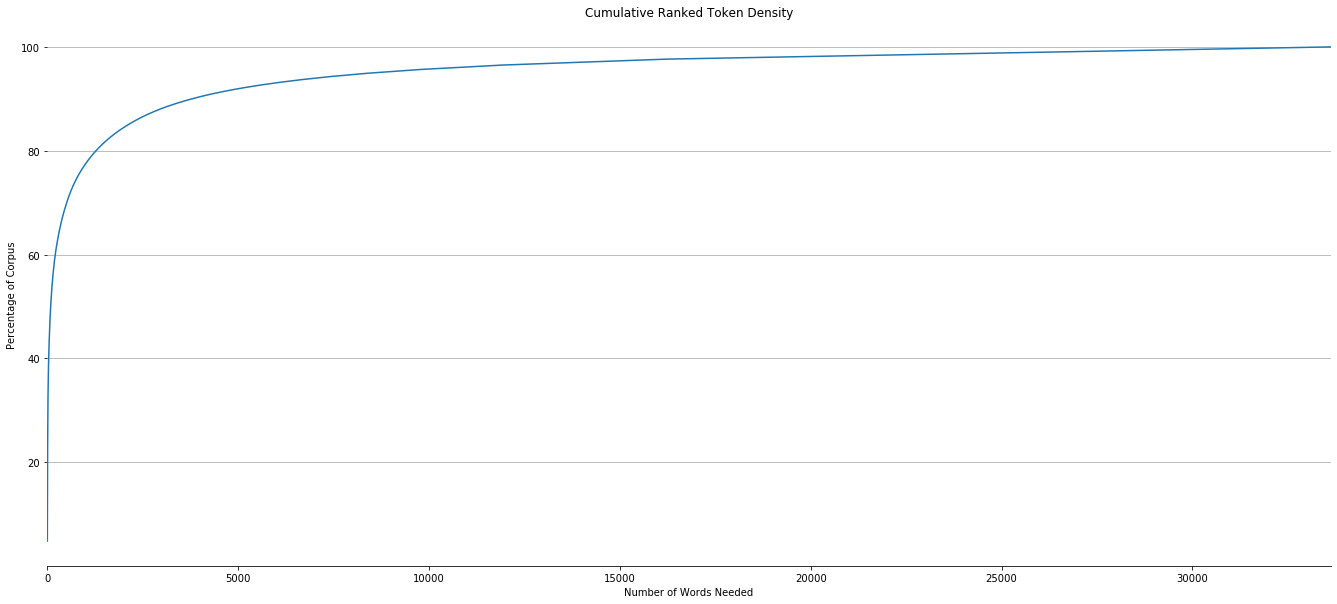


The above plot shows how many words you'd need to match X % of the corpus. This is useful if we want to explore predicting entire tokens at a time.
For example, we could use 1276 tokens to describe 80% of the corpus and lump the remaining 20% into a <unknown> column, drastically reducing the
number of columns we need in out input features. Realistically we're going to want a very high percentage of the tokens for best results. We'd need
3790 tokens to describe 90%, 8531 for 95%, and 26229 to describe 99%. This seems rather large for my limited GPU so we'll try removing capital letters.



In [8]:
min_words_fraction = 100 * value_counts.cumsum() / len(words)

fig, ax = plt.subplots()
ax.plot(range(len(min_words_fraction)), min_words_fraction)
ef.formatplot()
ax.set_title("Cumulative Ranked Token Density")
ax.set_ylabel("Percentage of Corpus")
ax.set_xlabel("Number of Words Needed")
plt.show()
print(
    """
The above plot shows how many words you'd need to match X % of the corpus. This is useful if we want to explore predicting entire tokens at a time.
For example, we could use {} tokens to describe 80% of the corpus and lump the remaining 20% into a <unknown> column, drastically reducing the
number of columns we need in out input features. Realistically we're going to want a very high percentage of the tokens for best results. We'd need
{} tokens to describe 90%, {} for 95%, and {} to describe 99%. This seems rather large for my limited GPU so we'll try removing capital letters.
""".format(
        (min_words_fraction < 80).sum(),
        (min_words_fraction < 90).sum(),
        (min_words_fraction < 95).sum(),
        (min_words_fraction < 99).sum(),
    )
)

In [9]:
words = tknzr.tokenize(" ".join(df.text.str.lower()))
value_counts = pd.value_counts(words)
print("Most probable characters: ")
print(value_counts.head(15))
print("-" * 20)
print("Number of non-unique tokens:")
print((value_counts > 1).sum())

Most probable characters: 
.      35412
the    24502
"      23793
!      20813
,      19804
to     14877
:      13774
a      11656
and    11225
is      9883
of      9704
in      9116
you     8483
for     7799
i       7527
dtype: int64
--------------------
Number of non-unique tokens:
12861


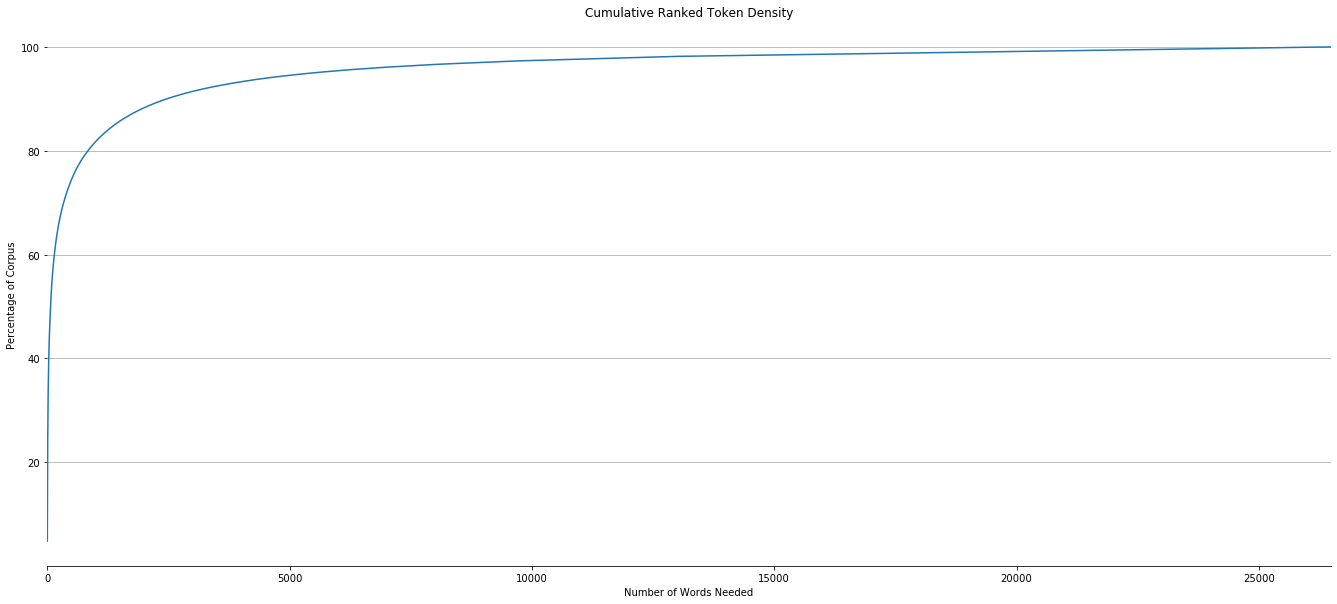


The above plot shows how many words you'd need to match X % of the corpus. This plot is when we have lowered all the uppercase characters in our
corpus. We'd need 839 tokens to describe 80% of the corpus, 2469 for 90%, 5481 for 95%, and 19089 to describe 99% of the corpus.
This still seems rather large so we'll also try using characters rather than entire tokens. This will mean the model will need to learn english words,
grammar, and punctuation which may prove even more of a challenge.



In [10]:
min_words_fraction = 100 * value_counts.cumsum() / len(words)

fig, ax = plt.subplots()
ax.plot(range(len(min_words_fraction)), min_words_fraction)
ef.formatplot()
ax.set_title("Cumulative Ranked Token Density")
ax.set_ylabel("Percentage of Corpus")
ax.set_xlabel("Number of Words Needed")
plt.show()
print(
    """
The above plot shows how many words you'd need to match X % of the corpus. This plot is when we have lowered all the uppercase characters in our
corpus. We'd need {} tokens to describe 80% of the corpus, {} for 90%, {} for 95%, and {} to describe 99% of the corpus.
This still seems rather large so we'll also try using characters rather than entire tokens. This will mean the model will need to learn english words,
grammar, and punctuation which may prove even more of a challenge.
""".format(
        (min_words_fraction < 80).sum(),
        (min_words_fraction < 90).sum(),
        (min_words_fraction < 95).sum(),
        (min_words_fraction < 99).sum(),
    )
)

### Character Distribution

In [11]:
char_counts = pd.value_counts(np.fromiter("".join(df.text), np.dtype("U1")))

char_counts.tail(15)

X    269
Z    230
Q    204
@    182
+     78
=     75
~     48
*     38
|     19
[     10
]      9
{      4
}      4
`      2
\      1
dtype: int64

Judging from the above we can probably remove the bottom 12 least likely punctuation points without causing ourselves too much trouble.

In [12]:
df["text"] = df.text.apply(ef.rmv_uncommon)

char_counts = pd.value_counts(np.fromiter("".join(df.text), np.dtype("U1")))

char_counts.tail(15)

)    1672
(    1614
3    1392
5    1314
4    1160
q    1072
7    1028
/     909
$     871
9     863
8     835
%     728
X     269
Z     230
Q     204
dtype: int64

Method succesfully removes un-needed characters!

## Text Feature Distributions


### Number of words:

In [9]:
count_words = lambda x: len(x.split(" "))
df["word_count"] = df["text"].apply(count_words)

# Remove anything that only contains a single word
df = df[df["word_count"] > 1]

In [10]:
df.sort_values("word_count").head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,ext_links,word_count
8633,Twitter for iPhone,773584728276475904,#AmericaFirst!,2016-09-07 18:12:26+00:00,8910,NaN,26714,False,1,2
25092,Twitter for iPhone,1024014645940633600,,2018-07-30 19:31:31+00:00,11916,NaN,53581,False,1,2
27356,Twitter Web Client,269178749826781184,Thanks!,2012-11-15 20:43:09+00:00,0,519335734.0,0,False,0,2
22221,Twitter Web Client,289830673085247488,Thanks.,2013-01-11 20:26:31+00:00,0,401472484.0,0,False,0,2
22219,Twitter Web Client,289831815240351744,Thanks.,2013-01-11 20:31:04+00:00,0,351255356.0,0,False,0,2


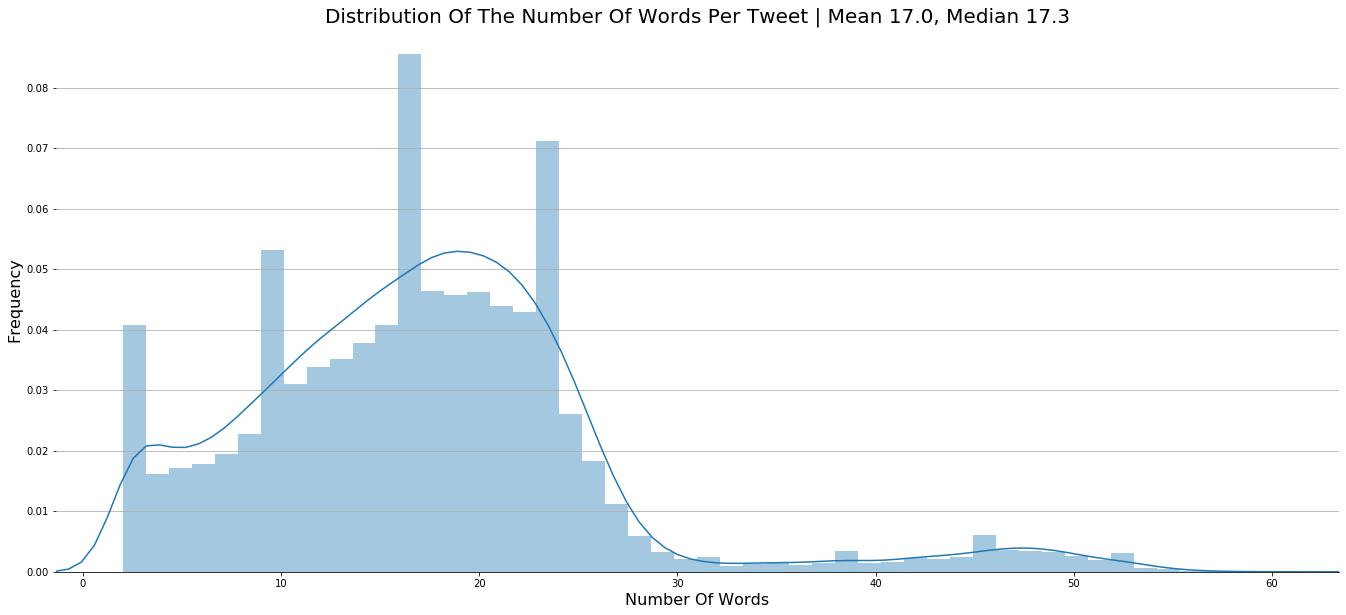

In [11]:
ef.distplot(df["word_count"].values, "number of words")
plt.show()

### Number of characters:

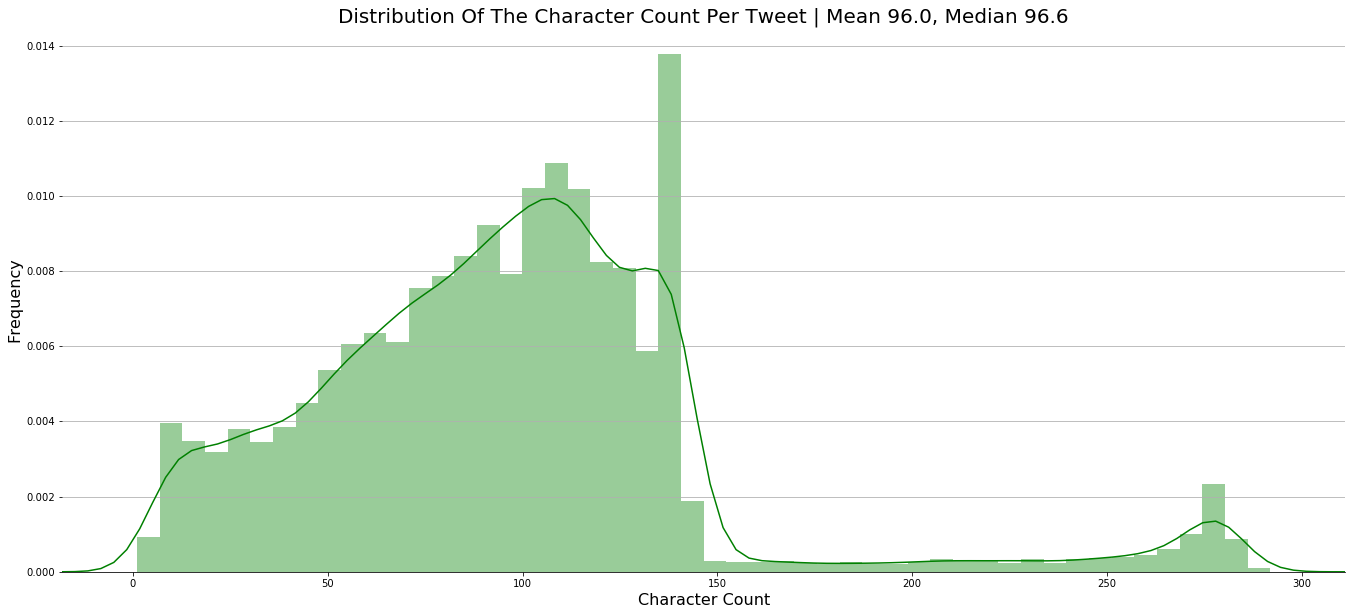

In [12]:
df["char_count"] = df["text"].str.len()  ## this also includes spaces
ef.distplot(df["char_count"].values, "character count", {"color": "green"})
plt.show()

### Number of stop words:

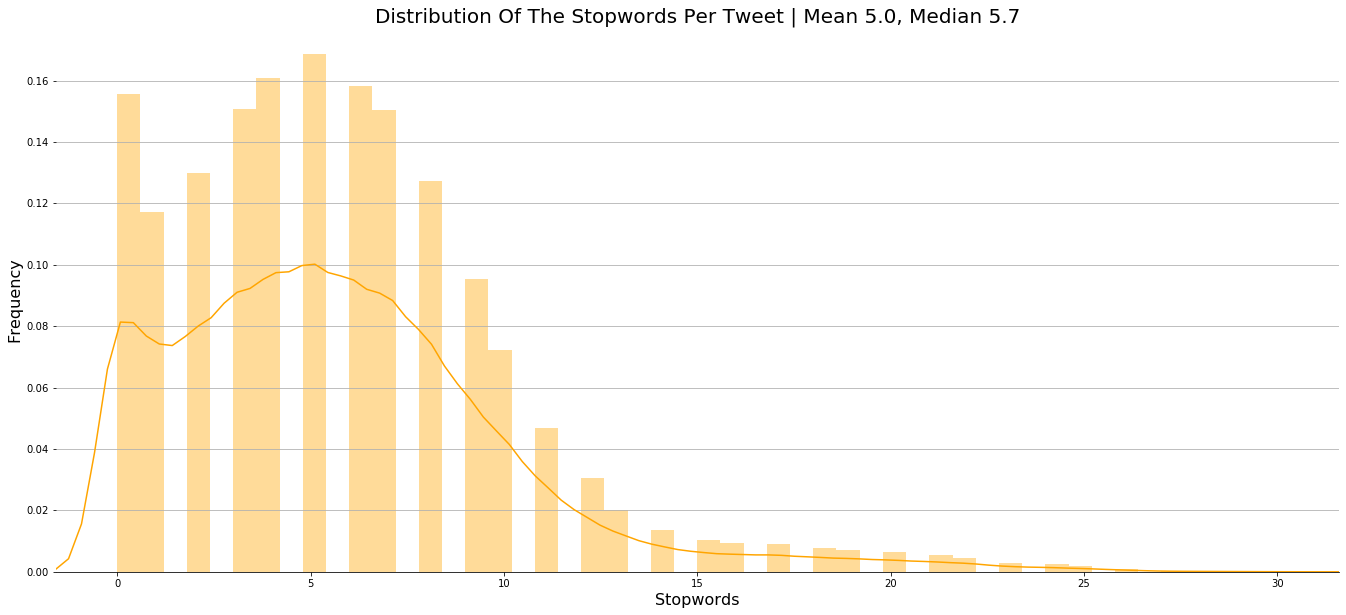

In [13]:
try:
    # Generate english stopword list - these are connector words that hold no information (except semantic)
    stopwords = nltk.corpus.stopwords.words("english")
except:
    nltk.download("stopwords")  # Common words to ignore
    nltk.download("punkt")  # Punkt Sentence Tokenizer - more useful in large documents

# Add stopwords data to df
count_stopwords = lambda x: len([x for x in x.split() if x in stopwords])
df["stopwords"] = df["text"].apply(count_stopwords)

ef.distplot(df.stopwords.values, "stopwords", {"color": "orange"})
plt.show()

Count number of hastags:

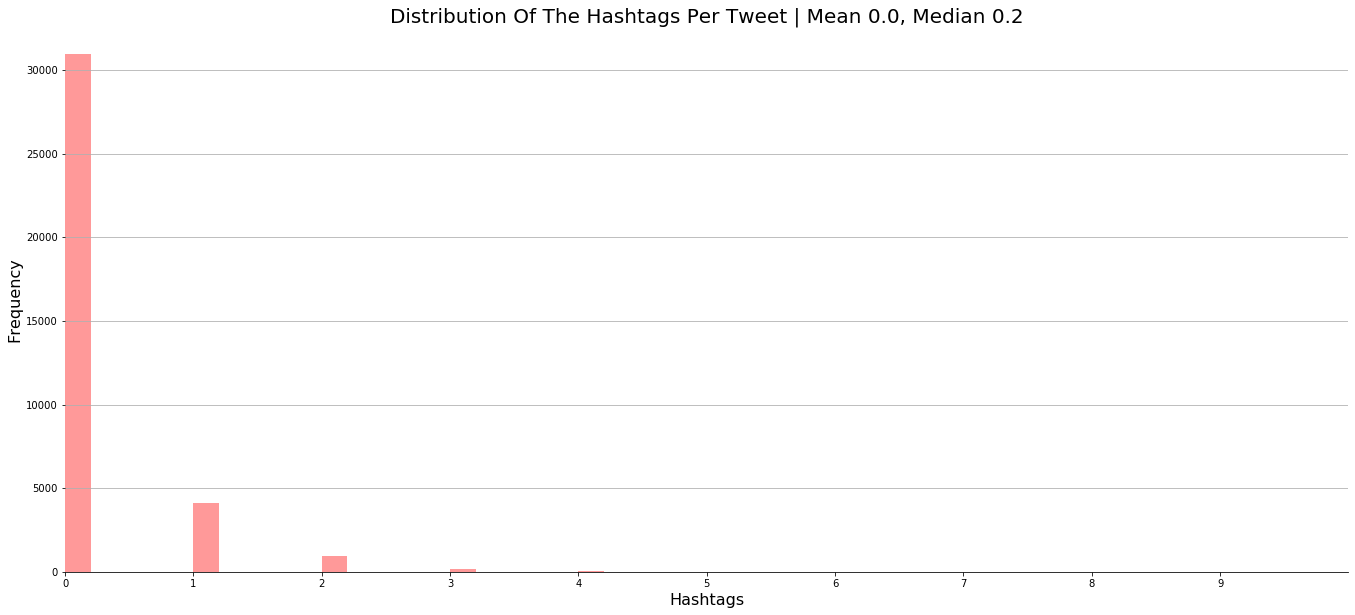

In [14]:
# Add hashtag count to df
count_hashtags = lambda x: len([x for x in x.split() if x.startswith("#")])
df["hashtags"] = df["text"].apply(count_hashtags)

fig = ef.distplot(df.hashtags.values, "hashtags", {"color": "red", "kde": False})
ax = fig.gca()
ax.set_xticks(np.arange(ax.get_xticks().max()))
plt.show()

Count the number of external links:

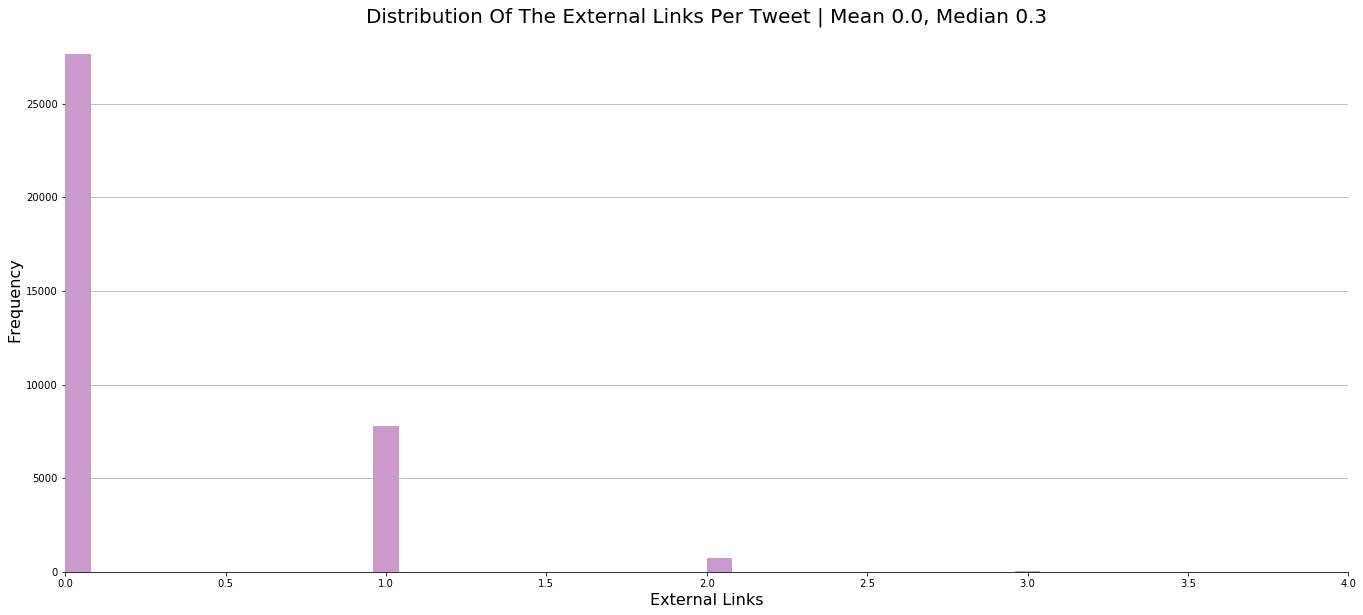

In [15]:
# Add external links to df, how much is donald linking to other sites?
ef.distplot(df.ext_links.values, "external links", {"color": "purple", "kde": False})
plt.show()

Count the number of numerics:

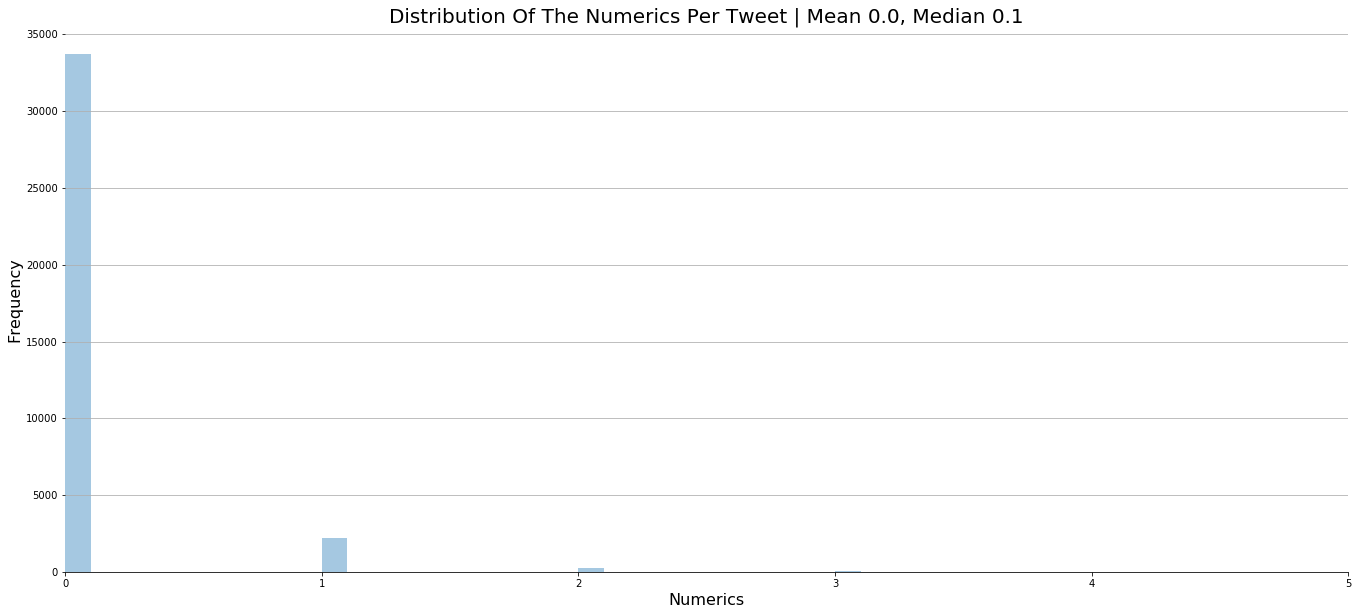

In [16]:
count_numerics = lambda x: len([x for x in x.split() if x.isdigit()])
df["numerics"] = df["text"].apply(count_numerics)
ef.distplot(df.numerics.values, "numerics", {"kde": False})
plt.show()

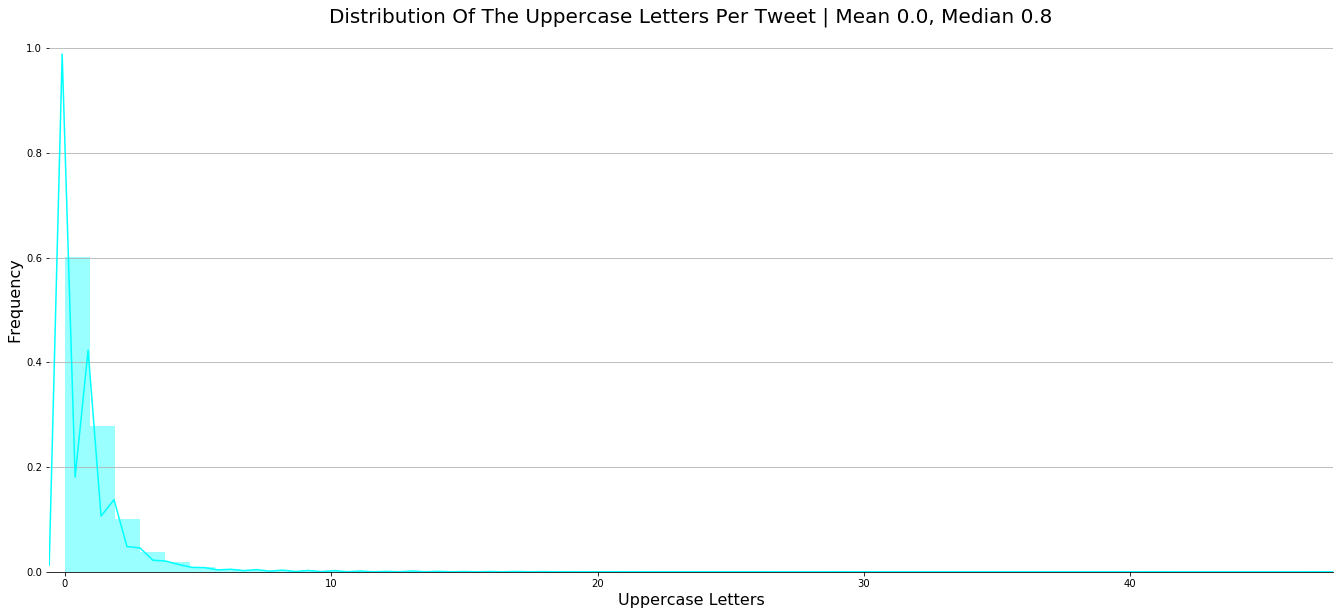

In [17]:
counter_uppercase = lambda x: len([x for x in x.split() if x.isupper()])
df["upper"] = df["text"].apply(counter_uppercase)
ef.distplot(df.upper.values, "Uppercase Letters", {"color": "aqua"})
plt.show()

### Remove retweets:
If we're trying to model how donald himself speaks we just want his own words.

In [18]:
df = df[df.is_retweet == False]
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,ext_links,word_count,char_count,stopwords,hashtags,numerics,upper
0,Twitter for Android,682703233492619264,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49+00:00,6776,NaN,16495,False,0,26,139,1,0,0,21
1,Twitter for Android,682700657304989696,"Do you believe that The State Department, on N...",2015-12-31 23:11:35+00:00,2755,NaN,6824,False,0,25,136,10,0,0,4
2,Twitter for iPhone,682635132038176768,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 18:51:12+00:00,2468,NaN,6047,False,2,17,86,4,0,0,5
3,Twitter for iPhone,682605293856002048,"HAPPY BIRTHDAY to my son, ! Very proud of you!...",2015-12-31 16:52:38+00:00,2080,NaN,8416,False,2,12,52,3,1,0,3
4,Twitter for Android,682578783912759296,I would feel sorry for and how badly he is doi...,2015-12-31 15:07:18+00:00,1875,NaN,5780,False,0,29,131,17,0,0,1


## Visualizations
#### Make Word Cloud
Hopefully this will give us an idea about trumps favourite words and topics

In [19]:
# remove stop words
stopwords += ["amp ", "&", " amp", "amp"]

word_list = " ".join(df["text"].values).split(" ")

word_bag = " ".join([word for word in word_list if word not in stopwords])

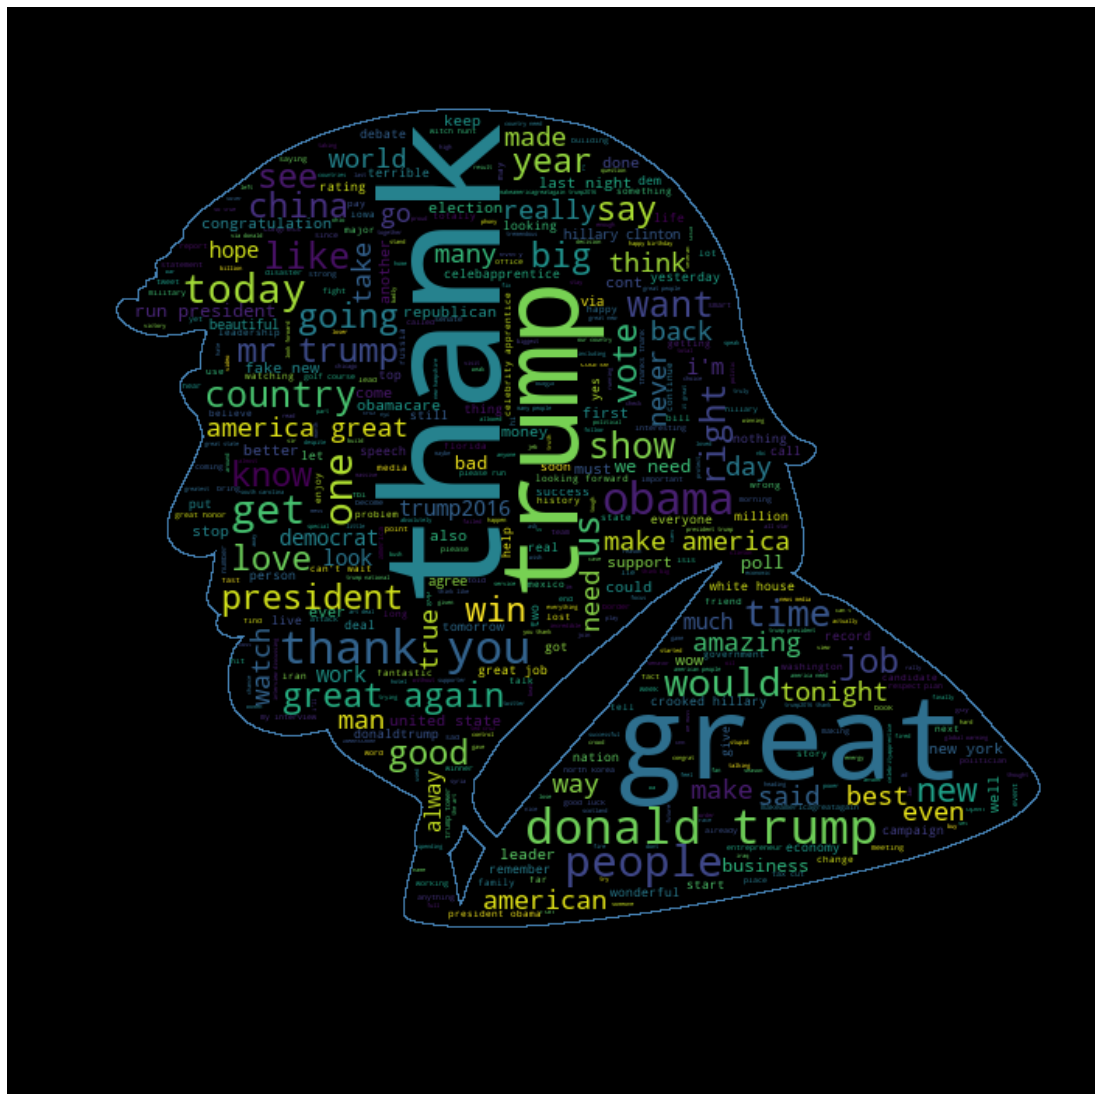

In [20]:
from PIL import Image

# Trump Mask
trump_mask = np.array(Image.open("./resources/trump.jpg"))

# Make image hard black and white, easier for word cloud
trump_mask = np.zeros_like(trump_mask) + (trump_mask > 150).astype(int) * 255

# remove stop words
stopwords = set(stopwords)

# Create and generate a word cloud image:
wordcloud = WordCloud(
    background_color="black",
    max_words=4000,
    mask=trump_mask,
    stopwords=stopwords,
    contour_width=1,
    contour_color="steelblue",
).generate(word_bag.lower())

# Display the generated image:
fig, ax = plt.subplots(1, 1, figsize=(23, 20))
_ = ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()

## How is trump changing the way he communicates over time?
#### Change in word length over time:

In [21]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,ext_links,word_count,char_count,stopwords,hashtags,numerics,upper
0,Twitter for Android,682703233492619264,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49+00:00,6776,NaN,16495,False,0,26,139,1,0,0,21
1,Twitter for Android,682700657304989696,"Do you believe that The State Department, on N...",2015-12-31 23:11:35+00:00,2755,NaN,6824,False,0,25,136,10,0,0,4
2,Twitter for iPhone,682635132038176768,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 18:51:12+00:00,2468,NaN,6047,False,2,17,86,4,0,0,5
3,Twitter for iPhone,682605293856002048,"HAPPY BIRTHDAY to my son, ! Very proud of you!...",2015-12-31 16:52:38+00:00,2080,NaN,8416,False,2,12,52,3,1,0,3
4,Twitter for Android,682578783912759296,I would feel sorry for and how badly he is doi...,2015-12-31 15:07:18+00:00,1875,NaN,5780,False,0,29,131,17,0,0,1


In [22]:
from string import ascii_letters


def count_letters(text):
    return len([t for t in text if t in ascii_letters])


def count_words(text):
    return text.count(" ") + 1


days, avgs = [], []

for date, sub_grp in df.text.groupby(df.created_at.dt.date):
    days.append(date)
    avgs.append(sub_grp.apply(count_letters).sum() / sub_grp.apply(count_words).sum())

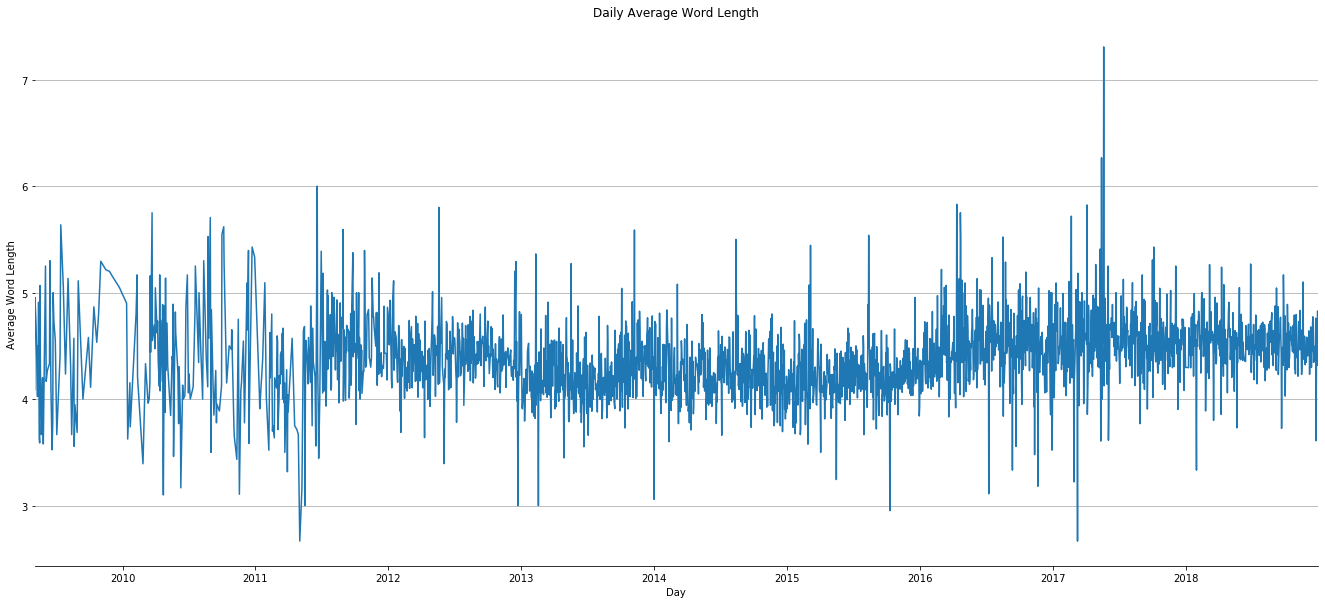

In [23]:
fig, ax = plt.subplots()
ax.plot(days, avgs)
ef.formatplot()
ax.set_title("Daily Average Word Length")
ax.set_ylabel("Average Word Length")
ax.set_xlabel("Day")
plt.show()

### Change in tweet popularity over time:

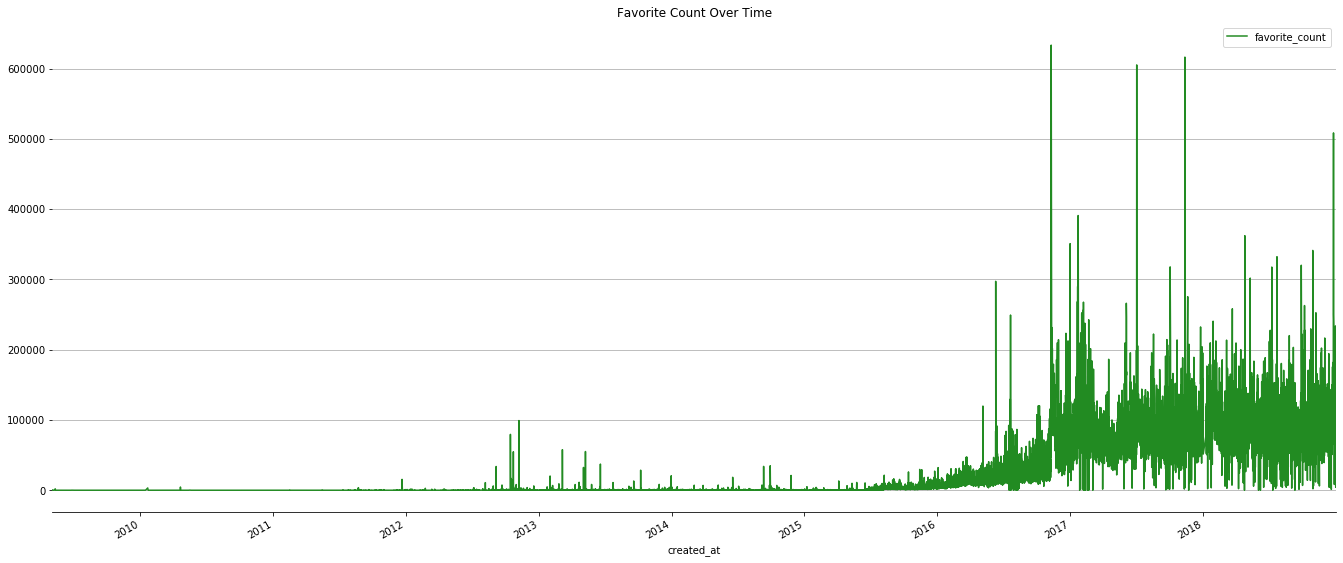

In [24]:
fig, ax = plt.subplots()
df.plot(x="created_at", y="favorite_count", ax=ax, c="forestgreen")
ef.formatplot()
ax.set_title("Favorite Count Over Time")
plt.show()

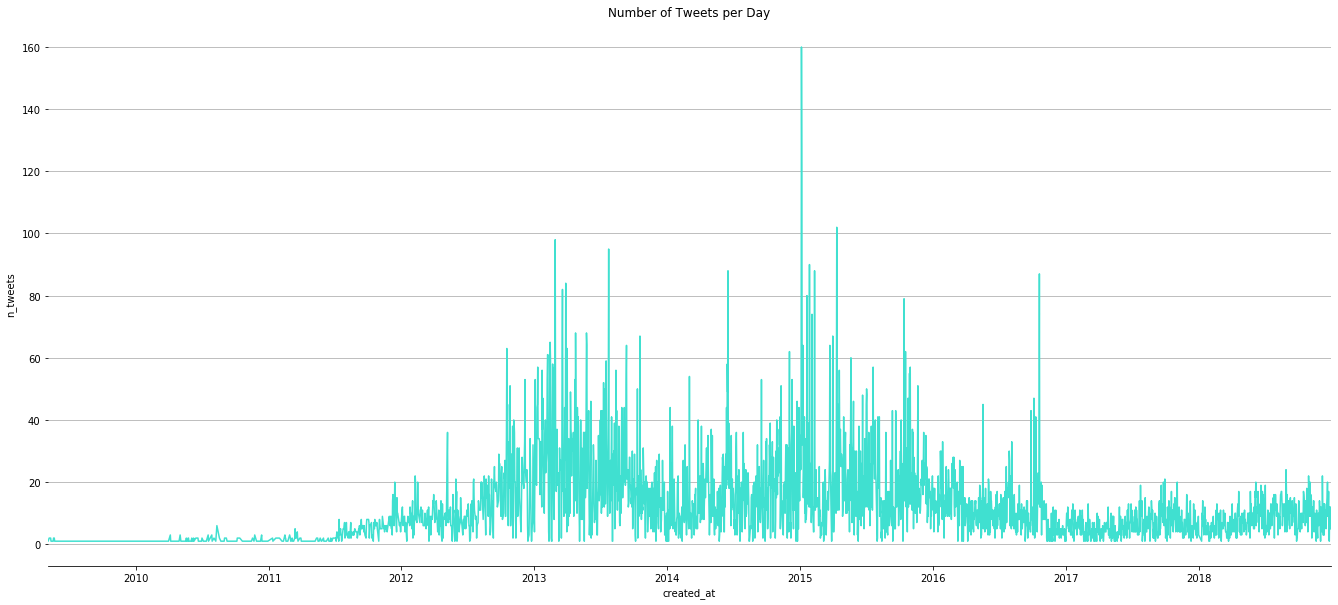

In [35]:
df.text.groupby(df.created_at.dt.date).count().plot(c="turquoise")
ef.formatplot()
ax = plt.gca()
ax.set_title("Number of Tweets per Day")
ax.set_ylabel("n_tweets")
plt.show()